# Adult Classifier with HELayers (HE) - Secure Aggregation in IBM FL

## Outline:
- [Add conda environment to Jupyter Notebook](#setup)
- [Federated Learning(FL)](#intro)
- [Why secure aggregation techniques are necessary?](#threats)
- [How does IBM FL Work with HE?](#HE-FL)
- [Aggregator](#Aggregator)
    - [Aggregator Configuration](#Aggregator-Configuration)
    - [Running the Aggregator](#Running-the-Aggregator)
- [Starting Parties](#Starting-Parties)
- [Training and Evaluation](#Training-and-Evaluation)
- [Visualize Results](#Visualize-Results)
- [Shut Down](#Shut-Down)

## Add conda environment to Jupyter Notebook <a name="setup"></a>

Please ensure that you have activated the `conda` environment following the instructions in the project README.

Once done, run the following commands in your terminal to install your conda environment into the Jupyter Notebook:

1. Once you have activated the conda environment, install the `ipykernel` package: `conda install -c anaconda ipykernel`

2. Next, install the `ipykernel` module within Jupyter Notebook: `python -m ipykernel install --user --name=<conda_env>`

3. Please install the `matplotlib` package for your conda environment.

4. Finally, restart the jupyter notebook once done. Ensure that you are running this Notebook from `<project_path>/Notebooks`, where project_path is the directory where the IBMFL repository was cloned.

When the Notebook is up and running it may prompt you to choose the kernel. Use the drop down to choose the kernel name same as that chosen when running `conda activate <conda_env>`. If no prompt shows up, you can change the kernel by clicking _Kernel_ > _Change kernel_ > _`<conda_env>`_.

## Federated Learning (FL) <a name="intro"></a>

**Federated Learning (FL)** is a distributed machine learning process in which each participant node (or party) retains their data locally and interacts with  other participants via a learning protocol. 
One main driver behind FL is the need to not share data with others  due to privacy and confidentially concerns.
Another driver is to improve the speed of training a machine learning model by leveraging other participants' training processes.

Setting up such a federated learning system requires setting up a communication infrastructure, converting machine learning algorithms to federated settings and in some cases knowing about the intricacies of security and privacy enabling techniques such as differential privacy and multi-party computation. 

In this Notebook we use [IBM FL](https://github.com/IBM/federated-learning-lib) together with Homomorphic Encryption to have multiple parties train a classifier to recognise handwritten digits in the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). 

For a more technical dive into IBM FL, refer the whitepaper [here](https://arxiv.org/pdf/2007.10987.pdf).

In the following cells, we set up each of the components of a Federated Learning network (See Figure below) wherein all involved parties aid in training their respective local cartpoles to arrive at the upright pendulum state. In this notebook we default to 2 parties, but depending on your resources you may use more parties.

<img style="display=block; margin:auto" src="../images/FL_Network.png" width="720"/>
<p style="text-align: center">Modified from Image Source: <a href="https://arxiv.org/pdf/2007.10987.pdf">IBM Federated Learning: An Enterprise FrameworkWhite Paper V0.1</a></p>

## Why secure aggregation techniques are necessary? <a name="threats"></a>

Federated Learning inherently provides some level of privacy because parties do not need to share their raw training data. However, some federations have stringent privacy requirements or are subject to regulation that may dictate that the system needs to add additional protection mechanisms to prevent inference of private information. <!--This raises risks for inference attacks on the training data from party updates. simply keeping the data at the party side is not sufficient for protecting privacy, since updates from a party may leak some information. In untrusted environments adversaries may try to infer information by analyzing other parties' replies.-->

<img style="display=block; margin:auto" src="../images/attack_surface.png" width="520"/>
<p style="text-align: center">Inferences over replies</p>

One inference attack to recover original training images from gradients exachanged between the aggregator and parties is shown below.

![SegmentLocal](../images/inference.gif "segment")
<p style="text-align: center">Taken from <a href="https://github.com/mit-han-lab/dlg"> Deep Leakage From Gradients     
</a></p>

Homomorphic Encryption can help us reduce the risk by hiding the final model from the aggregator and only revealing the aggregated version to the parties. Homomorphic Encryption is a crypto system that allows an entity to perform computations on encrypted data without decrypting it.  In other words, it enables the computation of a function over encrypted inputs and produces the result in encrypted form.  

<img style="display=block; margin:auto" src="../images/FHE_basics_2.png" width="720"/>
<p style="text-align: center">Homomorphic Encryption in Federated Learning</p>

## How does IBM FL work with HE? <a name="HE-FL"></a>

IBM FL uses the *[Cheon-Kim-Kim-Song (CKKS) scheme](https://eprint.iacr.org/2016/421.pdf)* for Homomorphic Encryption. HE functionalities are implemented using *[IBM HElayers software development kit (SDK)](https://github.com/IBM/helayers)*, and in particular, its *[PyHElayers](https://github.com/IBM/helayers#pyhelayers-python-package)* Python package. You can install `pyhelayers` in your conda environment by running `pip install pyhelayers`. Note that `pyhelayers` is currently supported only on Linux (x86 and IBM Z).

<img style="display=block; margin:auto" src="../images/ibmfl_helayer.png" width="512"/>
<p style="text-align: center">IBM FL library integrated with HELayers </p>

After enabling IBM FL with HE, the aggregator does not see model updates in plaintext. The aggregator sees encrypted model updates and performs aggregation under encryption, as shown in the figure below. 

![SegmentLocal](../images/FL_FHE_v3.gif "segment")
<p style="text-align: center">FL Training with HE</a></p>

### Getting things ready
We begin by setting the number of parties that will participate in the federated learning run and splitting up the data among them.

In [1]:
import sys
sys.path.append('../..')
import os
os.chdir("../..")

num_parties = 2  ## number of participating parties
dataset = 'adult'

We use `examples/generate_data.py` to split the dataset into files for each party. 

The script allows specifying the number of parties as well as the dataset to use (from several supported datasets: _mnist_, _femnist_, _cifar10_ and many others). 

The `-pp` argument states how many data points to choose per party. If the option `--stratify` is given, the library stratifies the data proportionally according to the source distribution. If you want to run this notebook in different machines, you can assign samples for each party locally. Then, we define the neural network definition.

In [2]:
%run examples/generate_data.py -n $num_parties -d $dataset -pp 200 

Finished! :) Data saved in examples/data/adult/random


Generate a pytorch model definition file using the below function `save_model_config`. Please note that parties data and the model file needs to be copied to the parties if you launch parties on different nodes.

In [3]:
import os
import joblib
from sklearn.linear_model import SGDClassifier

model_path = 'examples/configs/sklearn_logclassification'

model = SGDClassifier(loss='log', penalty='l2')
if not os.path.exists(model_path):
    os.makedirs(model_path)
fname = os.path.join(model_path, 'model_architecture.pickle')
with open(fname, 'wb') as f:
    joblib.dump(model, f)
print("Model file is generated successfully")

Model file is generated successfully


#### Set up Homomorphic Encryption (HE) Keys

The HE crypto system uses a public key and a secret key. As shown in the figure, secure aggregation using the HE crypto system requires the aggregator to obtain the public key and the parties to share the private key. In what follows, we will go into detail into how to generate the HE keys. 

<img style="display=block; margin:auto" src="../images/FL_HE_keys.png" width="512"/>
<p style="text-align: center">Parties share an HE private key, and share with the aggregator an HE public key.</p>

The easiest (and a recommended) way to generate HE keys is to run the `generate_store_HE_keys()` method that takes the following arguments:

- `path_for_public_key`: Path at which the public key file of HELayers will be stored.
- `path_for_secret_key`: Path at which the secret key file of HELayers will be stored.
- `HE_parames` (optional): Dictionary specifying the parametes of Homomorphic Encryption (HE). When using the default parameters, this argument is not required.

In HE-based aggregation in IBM-FL, all parties will have the access to the secret key. The aggregator will not have access to the secret key. It is worth noting that the secret key is used for decryption. Any entity that has an access to the secret key can decrypt the model updates from any party, and it is important that the parties protect the secret key.  

The public key file, often called as the context file, has the public key (along with some other parameters) required to perform homomorphic operations. In HE-based aggregation, the aggregator will have only the public key context file. Since the aggregator does not have the secret key, it cannot learn anything from the ciphertexts it receives from the parties. The aggregator performs aggregation under encryption (using the public key context file).

For details on HE parameters and how to set up custom parameters, see the tutorial on *Key Setup* (`notebooks/cryto_fhe_key_setup.ipynb`).

In [ ]:
from ibmfl.crypto.generate_store_HE_keys import generate_store_HE_keys

# Path for public key context file
ctx_file = os.path.join(os.getcwd(), 'notebooks/fhe.context')
# Path for secret key context file
key_file = os.path.join(os.getcwd(), 'notebooks/fhe.key')

generate_store_HE_keys(path_for_public_key = ctx_file, path_for_secret_key = key_file)

## Aggregator <a name="aggregator"></a>

Aggregator coordinates the overall process, communicates with the parties and integrates the results of the training process. This integration of results is done using the _Fusion Algorithm_.

A fusion algorithm queries the registered parties to carry out the federated learning process. The queries sent vary according to the model/algorithm type.  In return, parties send their reply as a model update object, and these model updates are then aggregated according to the specified Fusion Algorithm, specified via a `Fusion Handler` class. 

To take a look at the supported fusion algorithms, refer the IBM FL tutorial page [here](https://github.com/IBM/federated-learning-lib/blob/main/README.md#supported-functionality).

### Aggregator Configuration

We discuss the various configuration parameters for the Aggregator [here.](https://github.com/IBM/federated-learning-lib/blob/main/docs/tutorials/configure_fl.md#the-aggregators-configuration-file)

Given below is an example of the aggregator's configuration file. In this example, the aggregator does not specify a data file or maintain a global model. Hence, during the federated learning process, it only keeps track of the current model parameters. 

However, it is possible that the aggregator also has data for testing purposes and maintains a global model. When this is the case, one needs to add `data` and `model` sections in the configuration file.

<img style="display=block; margin:auto" src="../images/FHE_stacks.png" width="680"/>
<p style="text-align: center">Aggregator and Party side configurations</a></p>

In [5]:
agg_config = {
    'connection': {
        'info': {
            'ip': '127.0.0.1',
            'port': 5000,
            'tls_config': {
                'enable': 'false'
            }
        },
        'name': 'FlaskConnection',
        'path': 'ibmfl.connection.flask_connection',
        'sync': 'False'
    },
    'data': {
        'info': {
            'txt_file': 'examples/datasets/adult.data'
        },
        'name': 'AdultSklearnDataHandler',
        'path': 'ibmfl.util.data_handlers.adult_sklearn_data_handler'
    },
    'fusion': {
        'name': 'CryptoIterAvgFusionHandler',
        'path': 'ibmfl.aggregator.fusion.crypto_iter_avg_fusion_handler',
        'info': {
            'crypto': {
                'name': 'CryptoFHE',
                'path': 'ibmfl.crypto.helayer.fhe',
                'key_manager': {
                    'name': 'LocalDiskKeyManager',
                    'path': 'ibmfl.crypto.keys_mng.crypto_key_mng_dsk',
                    'key_mgr_info': {
                       'files': {
                            'context': ctx_file
                        }
                    }
                }
            }
        }
    },
    'hyperparams': {
        'global': {
            'num_parties': num_parties,
            'perc_quorum': 1,
            'rounds': 5,
            'termination_accuracy': 0.9
        },
        'local': {
            'training': {
                'max_iter': 2
            }
        }
    },
    'protocol_handler': {
        'name': 'ProtoHandler',
        'path': 'ibmfl.aggregator.protohandler.proto_handler'
    }
}

### Running the Aggregator
Next we pass the configuration parameters set in the previous cell to instantiate the `Aggregator` object. Finally, we `start()` the Aggregator process.

In [6]:
from ibmfl.aggregator.aggregator import Aggregator
aggregator = Aggregator(config_dict=agg_config)

aggregator.start()

2022-11-18 22:28:20,383 | 1.0.7 | INFO | ibmfl.util.config                             | Getting Aggregator details from arguments.
2022-11-18 22:28:20,386 | 1.0.7 | INFO | ibmfl.util.config                             | No metrics recorder config provided for this setup.
2022-11-18 22:28:20,387 | 1.0.7 | INFO | ibmfl.util.config                             | No model config provided for this setup.
2022-11-18 22:28:20,480 | 1.0.7 | INFO | ibmfl.util.config                             | No metrics config provided for this setup.
2022-11-18 22:28:20,481 | 1.0.7 | INFO | ibmfl.util.config                             | No evidencia recordeer config provided for this setup.
2022-11-18 22:28:20,482 | 1.0.7 | INFO | ibmfl.util.data_handlers.adult_sklearn_data_handler | Loaded training data from examples/datasets/adult.data


/home/swanand.kadhe/git-repos/FFL/ibmfl/util/data_handlers/adult_sklearn_data_handler.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_dataset['sex'] = training_dataset['sex'].map({' Female': 0, ' Male': 1})
/home/swanand.kadhe/git-repos/FFL/ibmfl/util/data_handlers/adult_sklearn_data_handler.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_dataset['race'] = training_dataset['race'].map(
/home/swanand.kadhe/git-repos/FFL/ibmfl/util/data_handlers/adult_sklearn_data_handler.py:161:

2022-11-18 22:28:28,273 | 1.0.7 | INFO | ibmfl.connection.flask_connection             | RestSender initialized
2022-11-18 22:28:28,275 | 1.0.7 | INFO | ibmfl.aggregator.protohandler.proto_handler   | State: States.START
2022-11-18 22:28:28,275 | 1.0.7 | INFO | ibmfl.aggregator.fusion.fusion_handler        | Warm start flag set to False.
2022-11-18 22:28:28,278 | 1.0.7 | INFO | ibmfl.crypto.crypto_library                   | Initializing a key manager
2022-11-18 22:28:28,280 | 1.0.7 | INFO | ibmfl.crypto.helayer.fhe                      | Initializing keys
2022-11-18 22:28:28,280 | 1.0.7 | INFO | ibmfl.crypto.helayer.fhe                      | Initializing a FHE Cipher
2022-11-18 22:28:28,302 | 1.0.7 | INFO | ibmfl.crypto.helayer.fhe                      | No flag for privacy of fusion weights in config. Setting to default value of False.
2022-11-18 22:28:28,302 | 1.0.7 | INFO | ibmfl.connection.flask_connection             | Receiver Initialized
2022-11-18 22:28:28,303 | 1.0.7 | INFO 

## Starting Parties <a name="parties"></a>

Now that we have Aggregator running, next we go to Parties' notebooks (`sklearn_classifier_p0.ipynb` and `sklearn_classifier_p1.ipynb`) to start and register them with the Aggregator. Once all the parties are done with registration, we will move to next step to start training.

## Training and Evaluation <a name="Training-and-Evaluation"></a>

Now that our network has been set up, we begin training the model by invoking the Aggregator's `start_training()` method. 

This could take some time, depending on your system specifications. Feel free to get your dose of coffee meanwhile ☕

In [7]:
"""
#1 Initialize the metrics collector variables
"""
num_parties = 2
eval_party_accuracy = [[] for _ in range(2)]
iterations = [[] for _ in range(2)]

"""
#2 Register handler for metrics collector
"""
def get_metrics(metrics):
    keys = list(metrics['party'].keys())
    keys.sort()
    for i in range(len(keys)):
      eval_party_accuracy[i].append(metrics['party'][keys[i]]['acc'])
      iterations[i].append(metrics['fusion']['curr_round']*3)
      
mh = aggregator.fusion.metrics_manager
mh.register(get_metrics)


"""
#3 start the training
"""
aggregator.start_training()

2022-11-18 22:31:30,272 | 1.0.7 | INFO | ibmfl.aggregator.aggregator                   | Initiating Global Training.
2022-11-18 22:31:30,274 | 1.0.7 | INFO | ibmfl.aggregator.fusion.fusion_handler        | Warm start disabled.
2022-11-18 22:31:30,275 | 1.0.7 | INFO | ibmfl.aggregator.fusion.crypto_iter_avg_fusion_handler | start_global_training: [round: 0] [model update: None]
2022-11-18 22:31:30,275 | 1.0.7 | INFO | ibmfl.aggregator.fusion.fusion_state_service  | Fusion state States.SND_MODEL
2022-11-18 22:31:30,276 | 1.0.7 | INFO | ibmfl.aggregator.protohandler.proto_handler   | State: States.SND_REQ
2022-11-18 22:31:30,298 | 1.0.7 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Total number of success responses :2
2022-11-18 22:31:30,300 | 1.0.7 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Number of parties queried:2
2022-11-18 22:31:30,301 | 1.0.7 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Number of registered parties:2
2022-11-18 22:31:30,303 | 1

2022-11-18 22:31:50,795 | 1.0.7 | INFO | ibmfl.aggregator.fusion.fusion_state_service  | Fusion state States.RCV_MODEL
2022-11-18 22:31:50,796 | 1.0.7 | INFO | ibmfl.aggregator.fusion.fusion_state_service  | Fusion state States.AGGREGATING
2022-11-18 22:31:50,796 | 1.0.7 | INFO | ibmfl.crypto.helayer.fhe                      | Start ciphertext fusing
2022-11-18 22:31:50,801 | 1.0.7 | INFO | ibmfl.crypto.helayer.fhe                      | Ciphertext fusion done
2022-11-18 22:31:50,802 | 1.0.7 | INFO | ibmfl.aggregator.fusion.crypto_iter_avg_fusion_handler | start_global_training: [round: 4] [model update: <ibmfl.model.model_update.ModelUpdate object at 0x7f7bd95e5f40>]
2022-11-18 22:31:50,803 | 1.0.7 | INFO | ibmfl.aggregator.fusion.fusion_state_service  | Fusion state States.SND_MODEL
2022-11-18 22:31:50,804 | 1.0.7 | INFO | ibmfl.aggregator.protohandler.proto_handler   | State: States.SND_REQ
2022-11-18 22:31:50,873 | 1.0.7 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Tota

True

## Visualize Results <a name="Visualize-Results"></a>

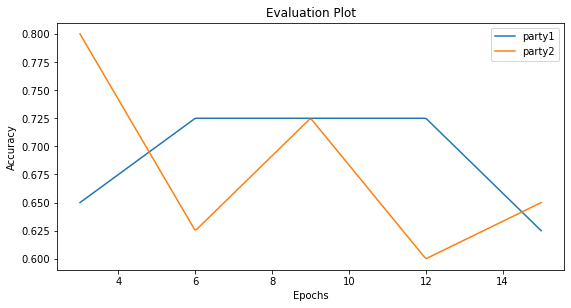

In [8]:
"""
#1 define a method to plot a smooth cure
"""
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np

def smooth_curve(xaxis, yaxis):
   xnew = np.linspace(min(xaxis), max(xaxis), len(xaxis)*50) 

   spl = make_interp_spline(xaxis, yaxis, k=1)  # type: BSpline
   power_smooth = spl(xnew)
   return xnew, power_smooth 

f = plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)

num_parties = agg_config['hyperparams']['global']['num_parties']


"""
#2 plot the evaluation curve
"""
for i in range(num_parties):
    eval_party_xaxis, eval_party_yaxis = smooth_curve(iterations[i], eval_party_accuracy[i])
    line1, = plt.plot(eval_party_xaxis, eval_party_yaxis)
    line1.set_label('party'+str(i+1))
plt.title('Evaluation Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## Shut Down

Invoke the `stop()` method on each of the network participants to terminate the service.

In [ ]:
aggregator.stop()